#### Importing packages 

In [ ]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', 60)


import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

# metrics
from sklearn.metrics import accuracy_score, classification_report, auc, make_scorer
from sklearn.metrics import confusion_matrix, recall_score 
from sklearn.metrics import f1_score, precision_score, roc_curve, precision_recall_curve, roc_auc_score

# folds
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

#ml models
# dummy classifier
from sklearn.dummy import DummyClassifier
#other classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

In [ ]:
# Read the csv file
url = "https://raw.githubusercontent.com/orkunaran/Stroke-Prediction/main/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(url)

In [ ]:
#spare a validation dataset
X_train, X_val, y_train, y_val = train_test_split(
    df.drop('stroke',axis=1),
    df.stroke,
    test_size = 0.1, 
    stratify = df.stroke.values,
    random_state= 42
    )

In [ ]:
df_train = X_train.copy(deep = True)
df_train['stroke'] = y_train

In [ ]:
df_train.info()
df_train['hypertension'] = df_train['hypertension'].astype('object')
df_train['heart_disease'] = df_train['heart_disease'].astype('object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4103 entries, 0 to 4102
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4103 non-null   object 
 1   age                4103 non-null   float64
 2   hypertension       4103 non-null   int64  
 3   heart_disease      4103 non-null   int64  
 4   ever_married       4103 non-null   object 
 5   work_type          4103 non-null   object 
 6   Residence_type     4103 non-null   object 
 7   avg_glucose_level  4103 non-null   float64
 8   bmi                3967 non-null   float64
 9   smoking_status     4103 non-null   object 
 10  stroke             4103 non-null   int64  
 11  kfold              4103 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 384.8+ KB


In [ ]:
# creating folds
df_train["kfold"] = -1
# the next step is to randomize the rows of the data
df_train = df_train.sample(frac=1).reset_index(drop=True)
y = df_train.stroke.values
# initiate the kfold class from model_selection module
kf = StratifiedKFold(n_splits=10)
# fill the new kfold column
for f, (t_, v_) in enumerate(kf.split(X=df_train, y=y)):
  df_train.loc[v_, 'kfold'] = f

#df.to_csv('stroke_fold.csv', index = False)


In [ ]:
useful_features = [col for col in df_train.columns if col not in ['kfold','stroke']]
object_cols = [col for col in df_train.select_dtypes('object').columns]
numeric_cols = [col for col in df_train.columns if col not in object_cols and col not in ['kfold','stroke']]

weight = len(df_train) / (df_train.stroke.nunique() * np.bincount(df_train.stroke.values))
spw = weight[1] / weight[0]

final_predictions = []
for fold in range(10):
  xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
  xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)
  xtest = X_val.copy()

  ytrain = xtrain.stroke
  yvalid = xvalid.stroke

  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]

  ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
  xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
  xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
  xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])

  standart_scaler = StandardScaler()
  xtrain[numeric_cols] = standart_scaler.fit_transform(xtrain[numeric_cols])
  xvalid[numeric_cols] = standart_scaler.transform(xvalid[numeric_cols])
  xtest[numeric_cols] = standart_scaler.transform(xtest[numeric_cols])

  imputer = KNNImputer(n_neighbors=10)
  xtrain = pd.DataFrame(imputer.fit_transform(xtrain), columns = xtrain.columns)
  xvalid = pd.DataFrame(imputer.transform(xvalid), columns = xvalid.columns)
  xtest = pd.DataFrame(imputer.transform(xtest), columns = xtest.columns)

  clf = XGBClassifier(random_state=fold, n_jobs=4, scale_pos_weight = spw)
  clf.fit(xtrain, ytrain, eval_set=[(xvalid,yvalid)],early_stopping_rounds=300,verbose=False)
  preds_valid = clf.predict(xvalid)
  test_preds = clf.predict(xtest)
  final_predictions.append(test_preds)
  print(fold, f1_score(yvalid, preds_valid), precision_score(yvalid,preds_valid))

0 0.36 0.23376623376623376
1 0.46874999999999994 0.36585365853658536
2 0.42857142857142855 0.36363636363636365
3 0.3333333333333333 0.22580645161290322
4 0.4262295081967213 0.3333333333333333
5 0.288659793814433 0.18666666666666668
6 0.31578947368421045 0.2054794520547945
7 0.2882882882882883 0.1797752808988764
8 0.36363636363636365 0.22727272727272727
9 0.36697247706422015 0.23255813953488372


In [ ]:
finals = np.mean(np.column_stack(final_predictions), axis=1)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val,finals)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

Best Threshold=0.100000, G-Mean=0.811


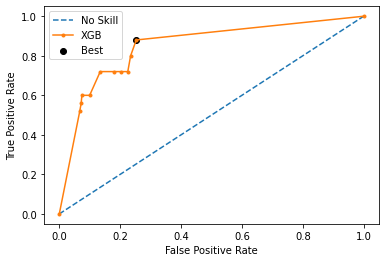

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGB')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
y_pred = [1 if x >= thresholds[ix] else 0 for x in finals]
tp, fp, tn, fn = metrics(y_val, y_pred)

results = results.append({'scale_pos_weight': spw,
                          'tp' : tp,
                          'fp' : fp,
                          'tn' : tn,
                          'fn' : fn,
                          'precision' : (tp / (tp + fp)),
                          'recall' : ((tp / (tp + fn)))},
                                      ignore_index = True)

In [ ]:
results

,scale_pos_weight,tp,fp,tn,fn,precision,recall
0,17.316964,22.0,3.0,322.0,109.0,0.88,0.167939


In [ ]:
ranges = [15,16,17,18,19,20]
for i in ranges:
  useful_features = [col for col in df_train.columns if col not in ['kfold','stroke']]
  object_cols = [col for col in df_train.select_dtypes('object').columns]
  numeric_cols = [col for col in df_train.columns if col not in object_cols and col not in ['kfold','stroke']]


  final_predictions = []
  final_valids = []
  for fold in range(10):
    xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
    xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)
    xtest = X_val.copy()

    ytrain = xtrain.stroke
    yvalid = xvalid.stroke

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
    xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])

    standart_scaler = StandardScaler()
    xtrain[numeric_cols] = standart_scaler.fit_transform(xtrain[numeric_cols])
    xvalid[numeric_cols] = standart_scaler.transform(xvalid[numeric_cols])
    xtest[numeric_cols] = standart_scaler.transform(xtest[numeric_cols])

    imputer = KNNImputer(n_neighbors=10)
    xtrain = pd.DataFrame(imputer.fit_transform(xtrain), columns = xtrain.columns)
    xvalid = pd.DataFrame(imputer.transform(xvalid), columns = xvalid.columns)
    xtest = pd.DataFrame(imputer.transform(xtest), columns = xtest.columns)

     
    clf = XGBClassifier(scale_pos_weight = i, random_state = fold)
    clf.fit(xtrain, ytrain, eval_set=[(xvalid,yvalid)],early_stopping_rounds=300,verbose=False)
    preds_valid = clf.predict(xvalid)
    test_preds = clf.predict(xtest)
    final_predictions.append(test_preds)
    

  finals = np.mean(np.column_stack(final_predictions), axis=1)
  fpr, tpr, thresholds = roc_curve(y_val,finals)
  # calculate the g-mean for each threshold
  gmeans = np.sqrt(tpr * (1-fpr))

  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)

  y_pred = [1 if x >= thresholds[ix] else 0 for x in finals]

  tp, fp, tn, fn = metrics(y_val, y_pred)

  results = results.append({'scale_pos_weight': i ,
                          'tp' : tp,
                          'fp' : fp,
                          'tn' : tn,
                          'fn' : fn,
                          'precision' : (tp / (tp + fp)),
                          'recall' : ((tp / (tp + fn)))},
                                      ignore_index = True)

display(results)

,scale_pos_weight,tp,fp,tn,fn,precision,recall
0,17.316964,22.0,3.0,322.0,109.0,0.88,0.167939
1,15.000000,16.0,9.0,397.0,34.0,0.64,0.320000
2,16.000000,16.0,9.0,397.0,34.0,0.64,0.320000
3,17.000000,21.0,4.0,327.0,104.0,0.84,0.168000
4,18.000000,22.0,3.0,330.0,101.0,0.88,0.178862
5,19.000000,21.0,4.0,332.0,99.0,0.84,0.175000
6,20.000000,20.0,5.0,328.0,103.0,0.80,0.162602


In [ ]:
# scale_pos_weight = 19 is the best model
useful_features = [col for col in df_train.columns if col not in ['kfold','stroke']]
object_cols = [col for col in df_train.select_dtypes('object').columns]
numeric_cols = [col for col in df_train.columns if col not in object_cols and col not in ['kfold','stroke']]

weight = len(df_train) / (df_train.stroke.nunique() * np.bincount(df_train.stroke.values))
spw = weight[1] / weight[0]

final_predictions = []
for fold in range(10):
  xtrain =  df_train[df_train.kfold != fold].reset_index(drop=True)
  xvalid = df_train[df_train.kfold == fold].reset_index(drop=True)
  xtest = X_val.copy()

  ytrain = xtrain.stroke
  yvalid = xvalid.stroke

  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]

  ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
  xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
  xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
  xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])

  standart_scaler = StandardScaler()
  xtrain[numeric_cols] = standart_scaler.fit_transform(xtrain[numeric_cols])
  xvalid[numeric_cols] = standart_scaler.transform(xvalid[numeric_cols])
  xtest[numeric_cols] = standart_scaler.transform(xtest[numeric_cols])

  imputer = KNNImputer(n_neighbors=10)
  xtrain = pd.DataFrame(imputer.fit_transform(xtrain), columns = xtrain.columns)
  xvalid = pd.DataFrame(imputer.transform(xvalid), columns = xvalid.columns)
  xtest = pd.DataFrame(imputer.transform(xtest), columns = xtest.columns)

  clf = XGBClassifier(random_state=fold, n_jobs=4, scale_pos_weight = 19)
  clf.fit(xtrain, ytrain, eval_set=[(xvalid,yvalid)],early_stopping_rounds=300,verbose=False)
  preds_valid = clf.predict(xvalid)
  test_preds = clf.predict(xtest)
  final_predictions.append(test_preds)
  print(fold, f1_score(yvalid, preds_valid), precision_score(yvalid,preds_valid))


finals = np.mean(np.column_stack(final_predictions), axis=1)
fpr, tpr, thresholds = roc_curve(y_val,finals)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

y_pred = [1 if x >= thresholds[ix] else 0 for x in finals]

tp, fp, tn, fn = metrics(y_val, y_pred)

0 0.3272727272727273 0.20689655172413793
1 0.46874999999999994 0.36585365853658536
2 0.37362637362637363 0.25
3 0.28846153846153844 0.18292682926829268
4 0.3516483516483516 0.2318840579710145
5 0.26666666666666666 0.1686746987951807
6 0.30303030303030304 0.19480519480519481
7 0.2162162162162162 0.1348314606741573
8 0.34234234234234234 0.21348314606741572
9 0.3478260869565218 0.21739130434782608


In [ ]:
# save scaler
import joblib
joblib.dump(ordinal_encoder, 'ordinal_encoder.gz')
joblib.dump(standart_scaler, 'standard_scaler.gz')
joblib.dump(imputer, 'knn_imputer.gz')

model_name = "stroke_xgb.pickle"
joblib.dump(clf, model_name)

['stroke_xgb.pickle']

In [ ]:
clf.save_model('stroke_xgb.json')